# zhang2019

This notebook loads the source file from a [figshare repository](https://doi.org/10.6084/m9.figshare.22226692) using [Pooch](https://www.fatiando.org/pooch), performs checks, applies corrections as needed, applies minimal cleaning steps, and exports a new file. The output file is uploaded manually to a Zenodo repository. The source file was previously analyzed and presented in [Zhang & Wamsley, 2019, _Psychophysiology_](https://doi.org/10.1111/psyp.13368) and is part of [the DREAM database](https://figshare.com/projects/The_Dream_EEG_and_Mentation_DREAM_database/158987) ([Wong et al., 2025, _Nat Commun_](https://doi.org/10.1038/s41467-025-61945-1)).

**See the [README file](./README.md) for details about the source data, processing steps, changes applied, and output data.**

**Notes**

The source file for this dataset is already version-controlled and pretty clean. The primary benefit of this repackaging is the reduction of file size and merging across a few files. The csv files of dream reports and metadata must be downloaded as part of a single 1GB zip file which can be restrictive in some scenarios.

## Setup

Load packages and pick global settings.

In [1]:
from csv import QUOTE_NONNUMERIC
import difflib
import os
import re
import textwrap
import urllib
import zipfile

import ftfy
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pooch
from wordcloud import WordCloud

from IPython.display import display

In [2]:
# Set pandas display options that apply whenever dataframes are displayed
pd.set_option("display.precision", 2)  # Number of decimal places to display on floats
pd.set_option("display.max_colwidth", 15)  # Number of characters to display in each column of text

## Load source data

Download source data from the internet using [Pooch](https://github.com/fatiando/pooch) and load the relevant files.

### Download files

Use Pooch to download and cache the 1GB zip file that has the dream reports, metadata, and also EEG data (which we won't use). The file will only be downloaded if it was not previously downloaded (Pooch tracks and manages this).

In [3]:
fname = pooch.retrieve(
    url="https://figshare.com/ndownloader/files/39504757",
    fname="Zhang & Wamsley 2019.zip",
    known_hash="md5:5854cfea4925f57d4d0a440518f4b72a",
    path=pooch.os_cache("pooch"),
    progressbar=True,
)

### Load files

Unzip the file and load/read the experimental description, dream reports, and metadata.

In [4]:
# Load the relevant files from the zip archive
REPORTS_NAME = "Zhang & Wamsley 2019/Data/Reports.csv"
RECORDS_NAME = "Zhang & Wamsley 2019/Records.csv"
DESCRIPTION_NAME = "Zhang & Wamsley 2019/ExperimentalDescription.txt"
with zipfile.ZipFile(fname) as zf:
    with zf.open(REPORTS_NAME, "r") as f:
        reports = pd.read_csv(f, encoding="utf-8")
    with zf.open(RECORDS_NAME, "r") as f:
        metadata = pd.read_csv(f, encoding="utf-8")
    with zf.open(DESCRIPTION_NAME, "r") as f:
        description = f.read().decode("utf-8")

# Wrap the description text for better display
STRING_WIDTH = 80
description = "\n".join(
    [textwrap.fill(line, width=STRING_WIDTH) for line in description.splitlines()]
)


### Merge files

Combine metadata (`Reports.csv`) with (`Records.csv`) into one dataframe. They both contain one row per dream report with `Case ID` being the linking key/column.

In [5]:
# Verify that we can merge the two dataframes on the three common columns
assert reports["Case ID"].is_unique, "All case IDs should be unique"
assert reports["Case ID"].equals(metadata["Case ID"]), "Case IDs should match between reports and metadata"
assert reports["Filename"].equals(metadata["Filename"]), "Filenames should match between reports and metadata"
assert reports["Subject ID"].equals(metadata["Subject ID"]), "Subject IDs should match between reports and metadata"

# Merge the two dataframes on the three common columns
df = pd.merge(metadata, reports, on=["Case ID", "Filename", "Subject ID"], validate="1:1")

### Snapshot - Source data

Provide a quick view of the relevant source data files.

In [6]:
# Define a function to print snapshot headings
def print_snapshot_heading(title: str, sep_line: bool = False) -> None:
    """Print a formatted heading for snapshot sections."""
    if sep_line:
        print("\n" + "=" * 80 + "\n")
    print(title)
    print("-" * len(title.strip()) + "\n")

In [7]:
print_snapshot_heading("Full text from `ExperimentalDescription.txt`:")
print(description)

Full text from `ExperimentalDescription.txt`:
---------------------------------------------

Dream EEG and Mentation (DREAM) data set


---Data set information---

Common name: Zhang & Wamsley 2019
Full name: N/A
Authors: Jing Zhang, Erin Wamsley
Location: Furman University, Greenville SC
Year: N/A
Set ID: 1
Amendment: 0
Corresponding author ID: 3
Download URL: [SET WHEN FINALIZED]

Previous publications:
Zhang, J., & Wamsley, E. J. (2019). EEG predictors of dreaming outside of REM
sleep. Psychophysiology, 56(7), e13368.

Correspondence:
Dr. Erin Wamsley: erin.wamsely@furman.edu

---Metadata---

Key ID: 1
Date entered: 2022-03-21T12:46:50+00:00
Number of samples: 308
Number of subjects: 28
Proportion REM: 12%
Proportion N1: 36%
Proportion N2: 50%
Proportion experience: 23%
Proportion no-experience: 77%
Proportion healthy: 100%
Provoked awakening: Yes
Time of awakening: Mixed
Form of response: Free
Date approved: 2022-03-21T13:09:17+00:00


---How to decode data files---

Sleep stage co

In [8]:
N_HEAD_ROWS = 5
print_snapshot_heading("Dataframe information")
df.info(verbose=True, memory_usage=True, show_counts=True)
print_snapshot_heading(f"Dataframe top {N_HEAD_ROWS} rows", sep_line=True)
with pd.option_context("display.max_colwidth", None):  # To show full dream reports
    display(df.head(n=N_HEAD_ROWS))
print_snapshot_heading("Dataframe numerical descriptive statistics", sep_line=True)
display(df.describe(include=[int, float]).T.astype({"count": int}).round(2))
print_snapshot_heading("Dataframe categorical descriptive statistics", sep_line=True)
display(df.describe(include=["object"]).T)

Dataframe information
---------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Filename                308 non-null    object 
 1   Case ID                 308 non-null    object 
 2   Subject ID              308 non-null    int64  
 3   Experience              308 non-null    int64  
 4   Treatment group         0 non-null      float64
 5   Duration                308 non-null    int64  
 6   EEG sample rate         308 non-null    int64  
 7   Number of EEG channels  308 non-null    int64  
 8   Last sleep stage        308 non-null    int64  
 9   Has EOG                 308 non-null    int64  
 10  Has EMG                 308 non-null    int64  
 11  Has ECG                 308 non-null    int64  
 12  Proportion artifacts    0 non-null      float64
 13  Time of awakening       308 non-null    object 
 1

,Filename,Case ID,Subject ID,Experience,Treatment group,Duration,EEG sample rate,Number of EEG channels,Last sleep stage,Has EOG,Has EMG,Has ECG,Proportion artifacts,Time of awakening,Subject age,Subject sex,Subject healthy,Has more data,Remarks,Text of Report
0,subject010_Morning.edf,10_Morning,10,2,NaN,73,400,58,5,1,1,0,NaN,7:17:27 AM,23,0,1,1,NaN,"I umm I was with my parents and we're having a quarrel over the best… And we're just I remember having a really hard figuring out where we should go. And uh, umm...umm...ummm...I'm just having a long, difficult discussion with my parents, and eating is part of it, but umm...I...its it lasted forever it's like a really long discussion.... umm I can't remember.. It was...I think it was about someone. it was about... it was also about stuff going on with people. It wasn't too.. It was kind of serious... ummm... that's it."
1,subject010_NREM.edf,10_NREM,10,2,NaN,73,400,58,2,1,1,0,NaN,2:07:02 AM,23,0,1,1,NaN,"Ummm... trying to put um everything together [inaudible word] [inaudible word] Um...so...um...putting together these um different rooms to help with um...to help with...umm...letting me...umm sleep. I was trying to find different rooms that could be good for me to..uhh... do this in actually, and ummm...and that was a problem where we tried finding me rooms and that was difficult because theres so many options to pick from and what kind of rooms you like. That's it."
2,subject010_REM.edf,10_REM,10,2,NaN,73,400,58,5,1,1,0,NaN,3:50:48 AM,23,0,1,1,NaN,"Yes I'm ummm... I'm in an argument with a...with a person and I am... then in argument I'm actually describing a dream to the other person about who's done it, and...umm they disagree with a decision I made, so they keep going on with the dream. So.. it was a point of contention...its very frustrating, just trying to resolve it calmly.. That's it."
3,subject010_SO1.edf,10_SO1,10,0,NaN,73,400,58,1,1,1,0,NaN,12:16:08 AM,23,0,1,1,NaN,What? I don't have a dream. What was your question? Ok.
4,subject010_SO10.edf,10_SO10,10,2,NaN,73,400,58,2,1,1,0,NaN,12:54:12 AM,23,0,1,1,NaN,Uhuh. Umm let's see.. Running around…(silence).




Dataframe numerical descriptive statistics
------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Subject ID,308,260.22,157.37,10.0,126.0,249.0,385.0,535.0
Experience,308,1.55,0.84,0.0,2.0,2.0,2.0,2.0
Treatment group,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,308,73.00,0.00,73.0,73.0,73.0,73.0,73.0
EEG sample rate,308,400.00,0.00,400.0,400.0,400.0,400.0,400.0
Number of EEG channels,308,58.00,0.00,58.0,58.0,58.0,58.0,58.0
Last sleep stage,308,1.40,1.38,0.0,0.0,1.0,2.0,5.0
Has EOG,308,1.00,0.00,1.0,1.0,1.0,1.0,1.0
Has EMG,308,1.00,0.00,1.0,1.0,1.0,1.0,1.0
Has ECG,308,0.00,0.00,0.0,0.0,0.0,0.0,0.0




Dataframe categorical descriptive statistics
--------------------------------------------



,count,unique,top,freq
Filename,308,308,subject010_...,1
Case ID,308,308,10_Morning,1
Time of awakening,308,301,12:22:42 AM,2
Text of Report,308,303,I don't rem...,4


## Clean metadata

#### Drop redundant columns (and extract `Actual sleep stage`)

Some information is present in multiple places, and other information is only present embedded within other values. For example, `Filename` values contain `Subject ID` and `Case ID`. Drop **after verifying their redundancy**.

**NOTE:** The sleep stages present in `Case ID` and `Filename` represent the _actual_ last sleep stage, identified post-hoc, which is different from the `Last sleep stage` column which represents the sleep stage identified in real-time during the study. This is mentioned in the `ExperimentalDescription.txt` printed above with relevant section re-printed below.

In [9]:
PATTERN = r"---How to decode data files---(.*?)--Treatment group codes--"
sleep_stage_description = re.search(PATTERN, description, re.DOTALL).group(1).strip()
print(sleep_stage_description)

Sleep stage codes in the filenames/Case IDs:

"SO#" = sleep onset reports collected after <=90sec of sleep. "#" represents the
order in which reports were collected.
NREM = reports intended to be collected following at least 10min of PSG-defined
N2
REM = reports intended to be collected following at least 5min of PSG-defined
REM sleep
Morning = a final report collected on morning awakening, regardless of sleep
stage

The INTENDED sleep stage indicated by these labels does not necessarily match
the ACTUAL sleep stage of the last epoch just before the dream report marker, as
listed in records.csv. This is for two reasons:
 1 - Sometimes, research assistants inadvertantly elicited reports from the
wrong sleep stage
 2 - In other cases, the dream report marker was delayed for a few seconds, and
a few seconds of wake preceeds the dream report marker, even though the
participant had mostly been asleep prior to the marker.

In our publication referenced here, we excluded reports that were con

In [10]:
# Extract `Subject ID` and `Actual last sleep stage` values
# from the `Case ID` and `Filename` columns and ensure consistency.
# WARNING: We are dropping the integer values attached to "SO" sleep stages.
# It is noted in the ExperimentalDescription.txt that this integer is the number of
# sequential awakenings (e.g., SO1, SO2, etc.), which we do not need to keep.
from_case = df["Case ID"].str.extract(r"^(?P<author>[0-9]+)_(?P<stage>[A-Za-z]+)[0-9]*$")
from_name = df["Filename"].str.extract(r"^subject0?(?P<author>[0-9]+)_(?P<stage>[A-Za-z]+)[0-9]*(?=\.edf$)")
assert df["Subject ID"].astype("string").eq(from_case["author"]).all(), "Subject IDs from `Case ID` should match `Subject ID` column"
assert df["Subject ID"].astype("string").eq(from_name["author"]).all(), "Subject IDs from `Filename` should match `Subject ID` column"
assert from_case["stage"].eq(from_name["stage"]).all(), "Sleep stage from `Case ID` should match sleep stage from `Filename`"

# Add the extracted sleep stage values as `Actual last sleep stage`
# and rename the existing `Last sleep stage` to `Intended last sleep stage` for clarity.

# Add back the sleep stage we extracted from the filename and Case ID
# NOT redundant with "Last sleep stage" because that is the stage at the end of the recording
df.insert(1, "Actual last sleep stage", from_case["stage"])
df = df.rename(columns={"Last sleep stage": "Intended last sleep stage"})

# Remove columns now verified as redundant
df = df.drop(columns=["Filename", "Case ID"])

# Remove completely empty columns
df = df.dropna(axis="columns", how="all")

#### Drop constant columns

This dataset has a lot of columns with constant values as a result of adding EEG metadata and being formatted for the DREAM database. These can be dropped since the primary goal here is to use the dataset independent of EEG analyses, and also because they are constant and easier to view as single values. The constant values are printed here in this notebook for reference.

In [11]:
# Identify all columns with constant values
constants = pd.Series(
    {col: df[col].iloc[0] for col in df if df[col].nunique(dropna=False) <= 1}
)

# Remove them from the dataframe that will continue on
df = df.drop(columns=constants.index)

# Print a record of which columns were removed and their constant values
print(
    f"Dropped {len(constants)} constant columns:\n\t" + "\n\t".join(
        [f"{col}: {constants[col]!s}" for col in constants.index]
    )
)
display(constants)

Dropped 8 constant columns:
	Duration: 73
	EEG sample rate: 400
	Number of EEG channels: 58
	Has EOG: 1
	Has EMG: 1
	Has ECG: 0
	Subject healthy: 1
	Has more data: 1


Duration                   73
EEG sample rate           400
Number of EEG channels     58
Has EOG                     1
Has EMG                     1
Has ECG                     0
Subject healthy             1
Has more data               1
dtype: int64

#### Value conversions

##### `Intended last sleep stage` integer to string

It is specified in the `ExperimentalDescription.txt` that `0 = last epoch before the report was WAKE`. We can assume that the other integer values follow standard sleep scoring codes.

In [12]:
SLEEP_STAGE_MAPPING = {0: "WAKE", 1: "N1", 2: "N2", 3: "N3", 5: "REM"}
assert df["Intended last sleep stage"].isin(SLEEP_STAGE_MAPPING.keys()).all(), "Check stage values"
df["Intended last sleep stage"] = df["Intended last sleep stage"].map(SLEEP_STAGE_MAPPING)

##### `Experience` integer to boolean

Convert `Experience` from integer to boolean. See relevant excerpt of `ExperimentalDescription.txt` printed below.

In [13]:
# Print the excerpt from description that describes the coding of the Experience column.
PATTERN = r"--DREAM categorization procedure--(.*?)---Technical details---"
experience_description = re.search(PATTERN, description, re.DOTALL).group(1).strip()
print(experience_description)

# Verify and convert Experience column to boolean
assert df["Experience"].isin([0, 2]).all(), "Check `Experience` values"
df["Experience"] = df["Experience"].astype(bool)

In this study, we define a “dream” as any mental experience recalled from sleep.
Reports were coded for the presence of dream content by 2 independent judges,
who were blind to sleep stage. For each report, judges assessed whether the
report contained a description of any mental content.

Participants were not asked to assess whether they might have been dreaming, but
failed to recall the dream. Therefore, the dream reports are coded only as:
0 = no experience
2 = experience


##### `Subject sex` integer to string

The mapping values were obtained by looking back at the value counts in the original paper.

In [14]:
SEX_MAPPING = {0: "Male", 1: "Female"}
assert df["Subject sex"].isin(SEX_MAPPING.keys()).all(), "Check `Subject sex` values"
df["Subject sex"] = df["Subject sex"].map(SEX_MAPPING)

##### `Time of awakening` 12-hour to 24-hour

`Time of awakening` is represented as a 12-hour (AM/PM) clock time without date. 24-hour format is a little more standard and less ambiguous.

In [15]:
df["Time of awakening"] = (
    pd.to_datetime(df["Time of awakening"], format="%I:%M:%S %p").dt.strftime("%H:%M:%S")
)

#### Reorder metadata columns in sensible sequence

This is minor but there is some expectation of information sequence when reading a column order.

In [16]:
AUTHOR_COL = "Subject ID"
REPORT_COL = "Text of Report"
METADATA_COLS = [
    "Subject age",
    "Subject sex",
    "Time of awakening",
    "Intended last sleep stage",
    "Actual last sleep stage",
    "Experience",
]
col_order = [AUTHOR_COL] + METADATA_COLS + [REPORT_COL]
assert df.columns.symmetric_difference(col_order).empty, "Current and future columns should match"
df = df.reindex(columns=col_order)

### Snapshot - Cleaned metadata

#### Dataframe

In [17]:
N_HEAD_ROWS = 2
df.info(verbose=True, memory_usage=True, show_counts=True)
print_snapshot_heading(f"Dataframe top {N_HEAD_ROWS} rows",)
display(df.head(n=N_HEAD_ROWS))
print_snapshot_heading("Dataframe numerical descriptive statistics", sep_line=True)
display(df.describe(include=[int, float]).T.astype({"count": int}).round(2))
print_snapshot_heading("Dataframe categorical descriptive statistics", sep_line=True)
display(df.describe(include=["object"]).T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Subject ID                 308 non-null    int64 
 1   Subject age                308 non-null    int64 
 2   Subject sex                308 non-null    object
 3   Time of awakening          308 non-null    object
 4   Intended last sleep stage  308 non-null    object
 5   Actual last sleep stage    308 non-null    object
 6   Experience                 308 non-null    bool  
 7   Text of Report             308 non-null    object
dtypes: bool(1), int64(2), object(5)
memory usage: 17.3+ KB
Dataframe top 2 rows
--------------------



,Subject ID,Subject age,Subject sex,Time of awakening,Intended last sleep stage,Actual last sleep stage,Experience,Text of Report
0,10,23,Male,07:17:27,REM,Morning,True,I umm I was...
1,10,23,Male,02:07:02,N2,NREM,True,Ummm... try...




Dataframe numerical descriptive statistics
------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Subject ID,308,260.22,157.37,10.0,126.0,249.0,385.0,535.0
Subject age,308,20.37,1.31,18.0,19.0,20.0,21.0,23.0




Dataframe categorical descriptive statistics
--------------------------------------------



,count,unique,top,freq
Subject sex,308,2,Male,202
Time of awakening,308,301,00:22:42,2
Intended last sleep stage,308,5,N2,105
Actual last sleep stage,308,4,SO,224
Text of Report,308,303,I don't rem...,4


#### Author metadata plots

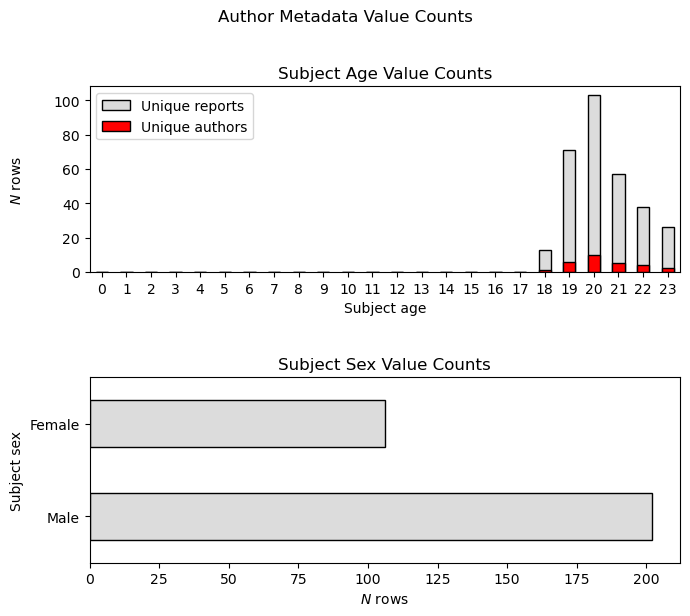

In [18]:
PLOT_KWARGS = {
    "color": "gainsboro",
    "edgecolor": "black",
}

fig, axes = plt.subplots(nrows=2, figsize=(7, 6))
age_ax, sex_ax = axes

AGE_COL = "Subject age"
assert df[AGE_COL].dtype == int, "Age column is expected to be of integer type"
age_categorical = (
    df[AGE_COL]
    .value_counts(dropna=False)
    .reindex(range(0, df[AGE_COL].max() + 1))
    .fillna(0)
    .astype(int)
)

age_categorical.plot(
    kind="bar",
    title=f"{AGE_COL} Value Counts".title(),
    xlabel=AGE_COL,
    ylabel=r"$N$ rows",
    label="Unique reports",
    ax=age_ax,
    **PLOT_KWARGS,
)

# Overlay unique author counts per age
author_counts = (
    df.groupby(AGE_COL)[AUTHOR_COL].nunique().reindex(range(0, df[AGE_COL].max() + 1))
)
author_counts.plot(
    kind="bar",
    color="red",
    edgecolor=PLOT_KWARGS["edgecolor"],
    label="Unique authors",
    ax=age_ax,
)
age_ax.legend()
age_ax.tick_params(axis="x", labelrotation="auto")

SEX_COL = "Subject sex"

df[SEX_COL].value_counts(dropna=False).plot(
    kind="barh",
    title=f"{SEX_COL} Value Counts".title(),
    xlabel=r"$N$ rows",
    ylabel=SEX_COL,
    ax=sex_ax, **PLOT_KWARGS
)

fig.suptitle("Author Metadata Value Counts", y=1.02)
fig.align_ylabels(axes)
fig.tight_layout(h_pad=3)

#### Dream report metadata plots

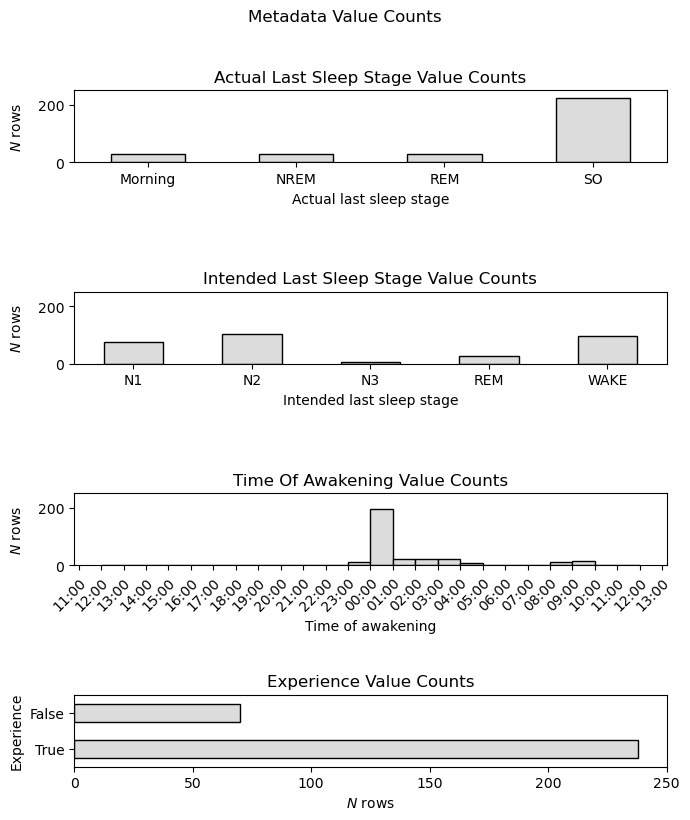

In [19]:
fig, axes = plt.subplots(nrows=4, figsize=(7, 8))
actualstage_ax, intendedstage_ax, time_ax, exp_ax = axes

ACTUAL_STAGE_COL = "Actual last sleep stage"
df[ACTUAL_STAGE_COL].value_counts(dropna=False).sort_index().plot(
    kind="bar",
    title=f"{ACTUAL_STAGE_COL} Value Counts".title(),
    xlabel=ACTUAL_STAGE_COL,
    ylabel=r"$N$ rows",
    ax=actualstage_ax,
    **PLOT_KWARGS,
)
actualstage_ax.tick_params(axis="x", labelrotation="auto")
actualstage_ax.set_ybound(upper=250)

INTENDED_STAGE_COL = "Intended last sleep stage"
df[INTENDED_STAGE_COL].value_counts(dropna=False).sort_index().plot(
    kind="bar",
    title=f"{INTENDED_STAGE_COL} Value Counts".title(),
    xlabel=INTENDED_STAGE_COL,
    ylabel=r"$N$ rows",
    ax=intendedstage_ax,
    **PLOT_KWARGS,
)
intendedstage_ax.tick_params(axis="x", labelrotation="auto")
intendedstage_ax.set_ybound(upper=250)

AWAKENING_COL = "Time of awakening"
times = pd.to_datetime(df[AWAKENING_COL], format="%H:%M:%S")
shifted_times = times.map(lambda x: x + pd.Timedelta(days=1) if x.hour < 12 else x)
bin_start = pd.Timestamp("1900-01-01 12:00:00")
bin_end = pd.Timestamp("1900-01-02 12:00:00")
bins = pd.date_range(start=bin_start, end=bin_end, periods=25)
time_ax.hist(shifted_times, bins=bins, color="gainsboro", edgecolor="black")
time_ax.set(title=f"{AWAKENING_COL} Value Counts".title(), xlabel=AWAKENING_COL, ylabel=r"$N$ rows")
time_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
time_ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
time_ax.set_ybound(upper=250)
time_ax.tick_params(axis="x", rotation=45)
for lbl in time_ax.get_xticklabels():
    lbl.set_rotation_mode("anchor")
    lbl.set_ha("right")

EXPERIENCE_COL = "Experience"
df[EXPERIENCE_COL].value_counts(dropna=False).plot(
    kind="barh",
    title=f"{EXPERIENCE_COL} Value Counts".title(),
    xlabel=r"$N$ rows",
    ylabel=EXPERIENCE_COL,
    ax=exp_ax,
    **PLOT_KWARGS,
)
exp_ax.set_xbound(upper=250)

fig.suptitle("Metadata Value Counts", y=1.02)
fig.align_ylabels(axes)
fig.tight_layout(h_pad=3)

## Clean dream reports

### Check for duplicates

Duplicated dream reports can be acceptable if they are from non-recall reports (e.g., "No dream."). But longer full dream reports being identical is highly unlikely. For this dataset, we can fortunately filter out non-recall dreams when checking.

In [20]:
# Show how no-recall reports can contain duplicates but it's acceptable.
duplicated_no_recall = df[~df[EXPERIENCE_COL] & df.duplicated(subset=REPORT_COL, keep=False)]
with pd.option_context("display.max_colwidth", None):  # To show full dream reports
    display(duplicated_no_recall[[AUTHOR_COL, REPORT_COL]])

,Subject ID,Text of Report
36,30,I don't remember.
91,181,I don't remember.
130,228,I don't remember.
180,337,I don't remember anything.
202,348,I don't remember.
204,348,I don't remember.
239,411,I don't remember.
242,411,I don't remember anything.


In [21]:
experiences = df[df[EXPERIENCE_COL]]
duplicates_all = experiences.duplicated(subset=[AUTHOR_COL, REPORT_COL], keep=False)
n_duplicates = experiences.duplicated(subset=[AUTHOR_COL, REPORT_COL], keep="first").sum()
print(f"Identified {n_duplicates} duplicated experience reports within authors.")
if n_duplicates > 0:
    print_snapshot_heading("Duplicate rows")
    display(duplicates_all[[AUTHOR_COL, REPORT_COL]])

Identified 0 duplicated experience reports within authors.


In [22]:
# There shouldn't be any dream reports duplicated across authors
duplicates_all = experiences.duplicated(subset=REPORT_COL, keep=False)
n_duplicates = experiences.duplicated(subset=REPORT_COL).sum()
print(f"Identified {n_duplicates} duplicated experience reports across authors.")
if n_duplicates > 0:
    print_snapshot_heading("Duplicate rows")
    display(duplicates_all[[AUTHOR_COL, REPORT_COL]])

Identified 0 duplicated experience reports across authors.


### Check UTF-8 encoding issues

In [23]:
audit_data = []

for idx, text in df[REPORT_COL].items():
    if not isinstance(text, str):
        continue
    explanation = ftfy.fix_and_explain(text)
    fixed_text = explanation.text
    if text == fixed_text:
        continue
    df.at[idx, REPORT_COL] = fixed_text
    logic_applied = " | ".join([" ".join(step) for step in explanation.explanation])
    matcher = difflib.SequenceMatcher(None, text, fixed_text)
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == "replace":
            orig = text[i1:i2]
            fix = fixed_text[j1:j2]
            while orig and fix and orig[0] == fix[0]:
                orig = orig[1:]; fix = fix[1:]; i1 += 1
            while orig and fix and orig[-1] == fix[-1]:
                orig = orig[:-1]; fix = fix[:-1]; i2 -= 1
            if orig or fix:
                audit_data.append({
                    "row_id": idx,
                    "original_char": orig,
                    "fixed_char": fix,
                    "original_context": f"[...]{text[max(0, i1-10):i2+10]}[...]",
                    "fixed_context": f"[...]{fixed_text[max(0, j1-10):j2+10]}[...]",
                    "explanations": logic_applied
                })

audit_df = pd.DataFrame(audit_data)
n_total_fixes = len(audit_df)
n_reports_fixed = 0 if audit_df.empty else audit_df["row_id"].nunique()
print(f"Applied {n_total_fixes} fixes across {n_reports_fixed} dream reports.")
if n_total_fixes > 0:
    with pd.option_context("display.max_colwidth", None):
        display(audit_df)

Applied 3 fixes across 3 dream reports.


,row_id,original_char,fixed_char,original_context,fixed_context,explanations
0,63,’,',[...]ream. that’s it. [...],[...]ream. that's it. [...],apply uncurl_quotes
1,116,’,',"[...]led, I don’t know why[...]","[...]led, I don't know why[...]",apply uncurl_quotes
2,186,’,',[...]I don’t really r[...],[...]I don't really r[...],apply uncurl_quotes


In [24]:
# Remove leading and/or trailing whitespace
print(
    "Identified",
    (df[REPORT_COL] != df[REPORT_COL].str.strip()).sum(),
    "reports with surrounding whitespace and stripped them."
)
df[REPORT_COL] = df[REPORT_COL].str.strip()

# Replace ellipsis characters with three periods
ellipsis = df[REPORT_COL].str.count("…")
n_ellipses = ellipsis.sum()
n_reports_with_ellipses = ellipsis.gt(0).sum()
df[REPORT_COL] = df[REPORT_COL].str.replace("…", "...", regex=False)
print(
    f"Replaced {n_ellipses} ellipsis characters with three periods",
    f"in {n_reports_with_ellipses} reports."
)

# Remove leading AND trailing quotes or dream reports
# that start and end with a quote, but are **not** one full quote.
quoted_patterns = [r"^'([^']+)'$", r'^"([^"]+)"$']
for pattern in quoted_patterns:
    n_matches = df[REPORT_COL].str.fullmatch(pattern).sum()
    if n_matches > 0:
        df[REPORT_COL] = df[REPORT_COL].str.replace(pattern, lambda m: m.group(1), regex=True)
    print(f"Identified {n_matches} reports with surrounding {pattern[1]} quotes and stripped them.")

Identified 156 reports with surrounding whitespace and stripped them.
Replaced 188 ellipsis characters with three periods in 98 reports.
Identified 0 reports with surrounding ' quotes and stripped them.
Identified 0 reports with surrounding " quotes and stripped them.


In [25]:
# See if any 'Replacement Characters' (�) survived the ftfy pass.
survived_errors = df[df[REPORT_COL].str.contains(r"\ufffd", na=False, regex=True)]
print(f"Replacement characters (data loss) still present in {len(survived_errors)} reports.")

Replacement characters (data loss) still present in 0 reports.


### Check extreme word counts

In [26]:
# Inspect reports with extremely low word counts to verify they are sensible.
word_counts = df[REPORT_COL].str.split().str.len()
short_dreams = df[word_counts <= 5]
print(f"Number of dreams reports with 5 or less words: {len(short_dreams)}")
if not short_dreams.empty:
    with pd.option_context("display.max_colwidth", None):
        display(short_dreams[[AUTHOR_COL, REPORT_COL]])

Number of dreams reports with 5 or less words: 25


,Subject ID,Text of Report
26,30,Yeah...What?...uh....uh......[largely blank]
28,30,I don't remember... Mmmm...That's all...
29,30,Mmmm.....Don't remember. That's all.
36,30,I don't remember.
41,42,Umm I can't remember anything.
47,83,I...I can't remember. Uh...I'm done.
91,181,I don't remember.
95,181,Mmm...Mmm...Mmm..I don't remember. Finished.
104,183,I don't remember. That's it.
107,183,I don't remember. I'm finished.


In [27]:
# Inspect reports with extremely high word counts to verify they are sensible.
long_dreams = df[word_counts >= 1000]
print(f"Number of dreams reports with 1000 or more words: {len(long_dreams)}")
if not long_dreams.empty:
    with pd.option_context("display.max_colwidth", None):
        display(long_dreams[[AUTHOR_COL, REPORT_COL]])

Number of dreams reports with 1000 or more words: 0


### Snapshot - Cleaned reports

#### Dataframe

In [28]:
N_HEAD_ROWS = 2
df.info(verbose=True, memory_usage=True, show_counts=True)
print_snapshot_heading(f"Dataframe top {N_HEAD_ROWS} rows",)
display(df.head(n=N_HEAD_ROWS))
print_snapshot_heading("Dataframe numerical descriptive statistics", sep_line=True)
display(df.describe(include=[int, float]).T.astype({"count": int}).round(2))
print_snapshot_heading("Dataframe categorical descriptive statistics", sep_line=True)
display(df.describe(include=["object"]).T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Subject ID                 308 non-null    int64 
 1   Subject age                308 non-null    int64 
 2   Subject sex                308 non-null    object
 3   Time of awakening          308 non-null    object
 4   Intended last sleep stage  308 non-null    object
 5   Actual last sleep stage    308 non-null    object
 6   Experience                 308 non-null    bool  
 7   Text of Report             308 non-null    object
dtypes: bool(1), int64(2), object(5)
memory usage: 17.3+ KB
Dataframe top 2 rows
--------------------



,Subject ID,Subject age,Subject sex,Time of awakening,Intended last sleep stage,Actual last sleep stage,Experience,Text of Report
0,10,23,Male,07:17:27,REM,Morning,True,I umm I was...
1,10,23,Male,02:07:02,N2,NREM,True,Ummm... try...




Dataframe numerical descriptive statistics
------------------------------------------



,count,mean,std,min,25%,50%,75%,max
Subject ID,308,260.22,157.37,10.0,126.0,249.0,385.0,535.0
Subject age,308,20.37,1.31,18.0,19.0,20.0,21.0,23.0




Dataframe categorical descriptive statistics
--------------------------------------------



,count,unique,top,freq
Subject sex,308,2,Male,202
Time of awakening,308,301,00:22:42,2
Intended last sleep stage,308,5,N2,105
Actual last sleep stage,308,4,SO,224
Text of Report,308,302,I don't rem...,6


### Text

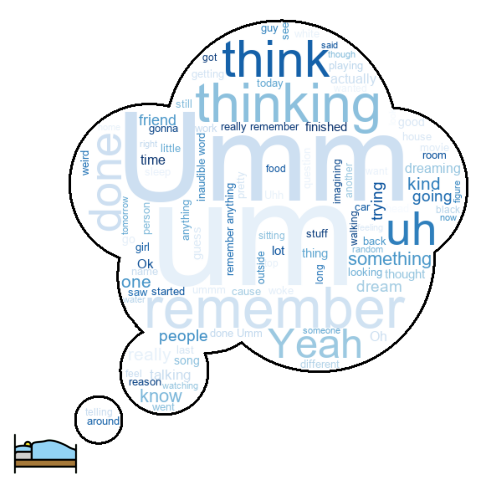

In [ ]:
bed_url = "https://openmoji.org/php/download_asset.php?type=emoji&emoji_hexcode=1F6CC&emoji_variant=color"
bubble_url = "https://openmoji.org/php/download_asset.php?type=emoji&emoji_hexcode=1F4AD&emoji_variant=color"

bubble_img = Image.open(urllib.request.urlopen(bubble_url))
bubble_img = bubble_img.convert("RGBA")
bed_img = Image.open(urllib.request.urlopen(bed_url))
bed_img = bed_img.convert("RGBA")

bubble_array = np.array(bubble_img)
bubble_mask = np.where(bubble_array[:, :, 3] > 0, 0, 255).astype(np.uint8)

arial_path = [
    f for f in plt.matplotlib.font_manager.findSystemFonts()
    if "arial.ttf" in f.lower()
][0]

text = df[REPORT_COL].str.cat(sep=" ")

wc = WordCloud(
    font_path=arial_path,
    background_color="white",
    height=400,
    width=400,
    max_words=100,
    mask=bubble_mask,
    colormap="Blues",
    contour_width=3,
    contour_color="black",
    random_state=42,
)
wc.generate(text)
wc_image = wc.to_image()

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.imshow(bed_img, extent=[0, 15, -2, 13], zorder=10)
ax.imshow(wc_image, extent=[0, 110, 0, 110], zorder=5)

ax.axis("off")
fig.tight_layout()

## Export

Perform final cleanup, checks, and export to file. Reload to verify nothing was corrupted during export and print out final file statistics.

#### Quality confirmation

Now that all edits are done, ensure that the final dataset follows all expected rules.

In [30]:
# Reset index for cleanliness and to allow equal comparison upon reloading.
df = df.reset_index(drop=True)

# Final assertions to make sure nothing was reintroduced during subsequent processing.
assert df.notna().all(axis=None), "There should be no empty/NaN cells"
assert df[REPORT_COL].map(len).gt(0).all(axis=None), "There should be no empty dream report strings"
assert df[df[EXPERIENCE_COL]].duplicated(subset=REPORT_COL).sum() == 0, (
    "There should be no duplicated reports within authors"
)
assert (df[REPORT_COL] == df[REPORT_COL].str.strip()).all(), (
    "There should be no leading/trailing whitespace in dream reports"
)

#### Write to file

Save final DataFrame as a CSV file.

In [31]:
OUTPATH = "output/zhang2019.csv"
os.makedirs("output", exist_ok=True)
df.to_csv(
    path_or_buf=OUTPATH,
    index=False,
    sep=",",
    mode="x",  # Switch to `w` to overwrite existing file
    encoding="utf-8-sig",  # Include sig/BOM for better compatibility with Excel
    lineterminator="\n",
    quoting=QUOTE_NONNUMERIC,
    quotechar='"',
    doublequote=True,
)

#### Read new data back in

Read the file back in to make sure it was not corrupted during output.

In [32]:
df_reloaded = pd.read_csv(OUTPATH)
assert df_reloaded.equals(df), "Reloaded dataframe should match original"

#### Print file details

Print details for later viewing and copying to `raw/README.md` file.

In [33]:
print("file:", os.path.basename(OUTPATH))
print("size:", os.path.getsize(OUTPATH) / 1e6, "MB")
print("md5:", pooch.file_hash(OUTPATH, alg="md5"))
print("sha256:", pooch.file_hash(OUTPATH, alg="sha256"))

file: zhang2019.csv
size: 0.09022 MB
md5: a61a3c56f4ee8c14e4a6466044df88f8
sha256: 7474a34fa01c7313315434fd96b044660f397cf780ff37d8d8e30fdceb616773
